# FDTD Meep

[Meep](https://meep.readthedocs.io/en/latest/) is a free, open source Finite Difference Time Domain (FDTD) simulator

You to install meep and MPB with:

mamba (faster conda)

```
mamba install pymeep=*=mpi_mpich_* -y
```

conda (slower)

```
conda install -c conda-forge pymeep=*=mpi_mpich_* -y
```

To update you can use

```
mamba update pymeep=*=mpi_mpich_* -y
```

Works only on Mac, Linux or windows [WSL](https://docs.microsoft.com/en-us/windows/wsl/)



gdsfactory `gmeep` plugin computes the transmission spectrum for Photonic planar components.

One of the advantages of using `gmeep` is that you only need to define your component once using gdsfactory, and automatically can simulate it in meep without having to define the geometry again.

For extracting Sparameters, `gmeep` automatically swaps the source between ports to compute the full Sparameters matrix.

- add monitors on each component port
- extend ports to go over the PML
- run simulation and compute Sparameter coefficients with proper ratios for each Sparameter. Monitors record Fourier Transform fields. Sparameter is a relationship of those parameters at different frequencies.

The resolution is in pixels/um, you should run with at least `resolution=30` for 1/30 um/pixel (33 nm/ pixel)

Notice that most examples run with `resolution=20` so they run fast.

Here are some examples on how to extract Sparameters in Meep in some planar devices.


```bash

         top view
              ________________________________
             |                               |
             | xmargin_left                  | port_extension
             |<--------->       port_margin ||<-->
          o2_|___________          _________||_o3
             |           \        /          |
             |            \      /           |
             |             ======            |
             |            /      \           |
          o1_|___________/        \__________|_o4
             |   |                 <-------->|
             |   |ymargin_bot   xmargin_right|
             |   |                           |
             |___|___________________________|

        side view
              ________________________________
             |                     |         |
             |                     |         |
             |                   zmargin_top |
             |xmargin_left         |         |
             |<---> _____         _|___      |
             |     |     |       |     |     |
             |     |     |       |     |     |
             |     |_____|       |_____|     |
             |       |                       |
             |       |                       |
             |       |zmargin_bot            |
             |       |                       |
             |_______|_______________________|



```

## Single core

Running on a single CPU core can be slow as the a single core needs to update all the simulation grid points sequentially.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gdsfactory as gf
import gdsfactory.simulation.gmeep as gm

gf.config.set_plot_options(show_subports=False, show_ports=False)

2022-06-30 06:12:29.334 | INFO     | gdsfactory.config:<module>:52 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 5.12.4


2022-06-30 06:12:30.602 | INFO     | gdsfactory.simulation.gmeep:<module>:28 - Meep '1.23.0' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep']


Using MPI version 4.0, 1 processes


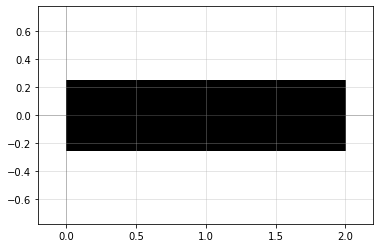

straight_length2: uid 0, ports ['o1', 'o2'], aliases [], 4 polygons, 0 references

In [2]:
c = gf.components.straight(length=2)
c

`run=False` only plots the simulations for you to review that is set up **correctly**

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep/__init__.py:4472: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


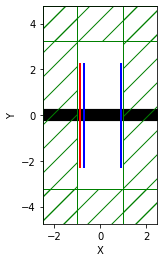

In [3]:
df = gm.write_sparameters_meep(c, run=False, ymargin_top=3, ymargin_bot=3)

In [4]:
help(gm.write_sparameters_meep)

Help on cython_function_or_method in module gdsfactory.simulation.gmeep.write_sparameters_meep:

write_sparameters_meep(component: Union[str, Callable[..., gdsfactory.component.Component], gdsfactory.component.Component, Dict[str, Any]], port_symmetries: Optional[Dict[str, Dict[str, List[str]]]] = None, resolution: int = 30, wavelength_start: float = 1.5, wavelength_stop: float = 1.6, wavelength_points: int = 50, dirpath: Union[str, pathlib.Path, NoneType] = None, layer_stack: Optional[gdsfactory.tech.LayerStack] = None, port_margin: float = 2, port_monitor_offset: float = -0.1, port_source_offset: float = -0.1, filepath: Optional[pathlib.Path] = None, overwrite: bool = False, animate: bool = False, lazy_parallelism: bool = False, run: bool = True, dispersive: bool = False, xmargin: float = 0, ymargin: float = 3, xmargin_left: float = 0, xmargin_right: float = 0, ymargin_top: float = 0, ymargin_bot: float = 0, **settings) -> pandas.core.frame.DataFrame
    Compute Sparameters and write

As you've noticed we added `ymargin_top` and `ymargin_bot` to ensure we have enough distance to the PML

You can also do this directly with another version of the function that adds `ymargin_top` and `ymargin_bot`

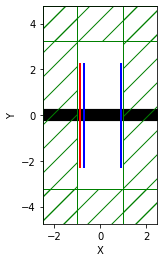

In [5]:
c = gf.components.straight(length=2)
df = gm.write_sparameters_meep(c, run=False)

Because components with `left-right` ports are very common `write_sparameters_meep` `y_margin = 3um `

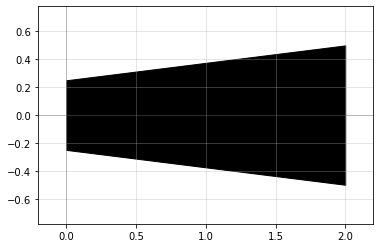

taper_length2p0_width21: uid 10, ports ['o1', 'o2'], aliases [], 3 polygons, 0 references

In [6]:
c = gf.components.taper(length=2.0, width1=0.5, width2=1)
c

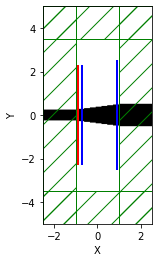

In [7]:
df = gm.write_sparameters_meep(c, run=False)

In [8]:
df = gm.write_sparameters_meep(c, resolution=20)

2022-06-30 06:12:31.325 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:345 - Simulation loaded from PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/taper_length2p0_width21_ae267354.csv')


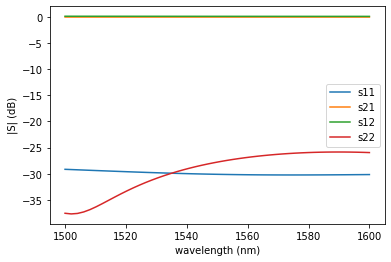

In [9]:
gf.simulation.plot.plot_sparameters(df)

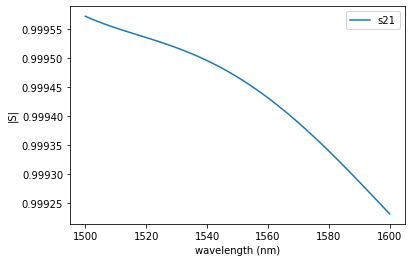

In [10]:
gf.simulation.plot.plot_sparameters(df, keys=("s21m",), logscale=False)

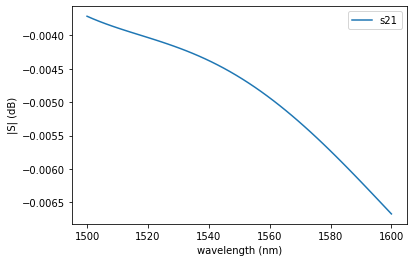

In [11]:
gf.simulation.plot.plot_sparameters(df, keys=("s21m",))

For a small taper S21 (Transmission) is around 0dB (100% transmission)

## Port symmetries

You can save some simulations in reciprocal devices.
If the device looks the same going from in -> out as out -> in, we only need to run one simulation

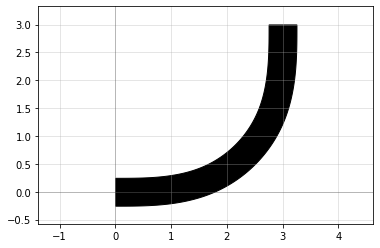

bend_euler_radius3: uid 16, ports ['o1', 'o2'], aliases [], 4 polygons, 0 references

In [12]:
c = gf.components.bend_euler(radius=3)
c

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep/__init__.py:4472: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


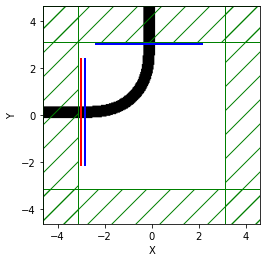

In [13]:
df = gm.write_sparameters_meep_1x1_bend90(c, run=False)

In [14]:
df = gm.write_sparameters_meep_1x1_bend90(c, run=True)

2022-06-30 06:12:33.123 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:345 - Simulation loaded from PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/bend_euler_radius3_4c26976e.csv')


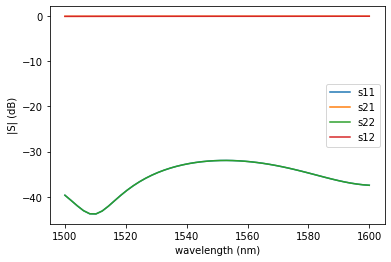

In [15]:
gf.simulation.plot.plot_sparameters(df)

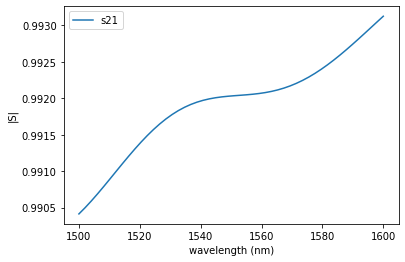

In [16]:
gf.simulation.plot.plot_sparameters(df, keys=("s21m",), logscale=False)

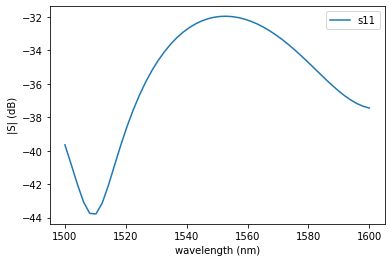

In [17]:
gf.simulation.plot.plot_sparameters(df, keys=("s11m",))

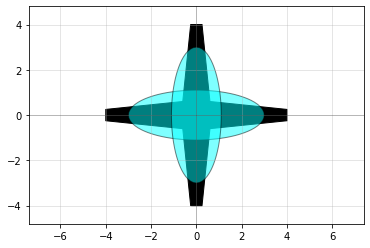

crossing: uid 23, ports ['o1', 'o3', 'o4', 'o2'], aliases [], 5 polygons, 0 references

In [18]:
c = gf.components.crossing()
c

Here are the port symmetries for a crossing

```python
port_symmetries = {
    "o1": {
        "s11": ["s22", "s33", "s44"],
        "s21": ["s12", "s34", "s43"],
        "s31": ["s13", "s24", "s42"],
        "s41": ["s14", "s23", "s32"],
    }
}
```

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep/__init__.py:4472: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


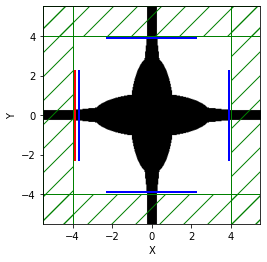

In [19]:
df = gm.write_sparameters_meep(
    c,
    resolution=20,
    ymargin=0,
    port_symmetries=gm.port_symmetries.port_symmetries_crossing,
    run=False,
)

In [20]:
df = gm.write_sparameters_meep(
    c,
    resolution=20,
    ymargin=0,
    port_symmetries=gm.port_symmetries.port_symmetries_crossing,
    run=True,
)

2022-06-30 06:12:34.266 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:345 - Simulation loaded from PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/crossing_073b4930.csv')


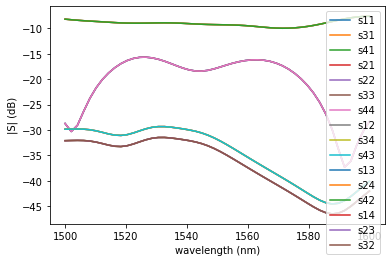

In [21]:
gm.plot.plot_sparameters(df)

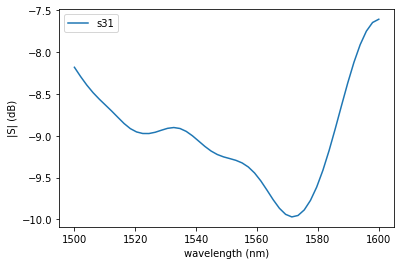

In [22]:
gm.plot.plot_sparameters(df, keys=("s31m",))

As you can see this crossing looks beautiful but is quite **lossy** (9dB @ 15550nm)

## Multicore (MPI)

You can divide each simulation into multiple cores thanks to [MPI (message passing interface)](https://en.wikipedia.org/wiki/Message_Passing_Interface)

Lets try to reproduce the coupler results from the [Meep docs](https://meep.readthedocs.io/en/latest/Python_Tutorials/GDSII_Import/)

According to the simulations in the doc to get a 3dB (50%/50%) splitter you need 150nm over 8um

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import gdsfactory as gf
import gdsfactory.simulation as sim
import gdsfactory.simulation.gmeep as gm

In [24]:
help(gf.components.coupler)

Help on function coupler in module gdsfactory.components.coupler:

coupler(gap: float = 0.236, length: float = 20.0, coupler_symmetric: Union[str, Callable[..., gdsfactory.component.Component], gdsfactory.component.Component, Dict[str, Any]] = <function coupler_symmetric at 0x7fb57140e820>, coupler_straight: Union[str, Callable[..., gdsfactory.component.Component], gdsfactory.component.Component, Dict[str, Any]] = <function coupler_straight at 0x7fb57140e5e0>, dy: float = 5.0, dx: float = 10.0, cross_section: Union[str, Callable[..., gdsfactory.cross_section.CrossSection], gdsfactory.cross_section.CrossSection, Dict[str, Any]] = 'strip', **kwargs) -> gdsfactory.component.Component
    Symmetric coupler.
    
    Args:
        gap: between straights in um.
        length: of coupling region in um.
        coupler_symmetric.
        coupler_straight.
        dy: port to port vertical spacing in um.
        dx: length of bend in x direction in um.
        cross_section: spec (CrossSection

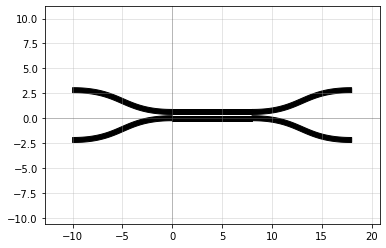

coupler_gap0p13_length8: uid 29, ports ['o1', 'o2', 'o3', 'o4'], aliases [], 21 polygons, 0 references

In [25]:
c = gf.components.coupler(length=8, gap=0.13)
c

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep/__init__.py:4472: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


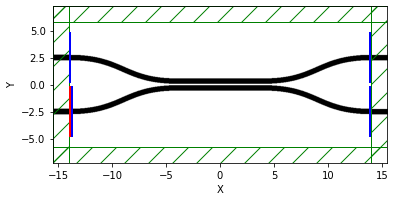

In [26]:
gm.write_sparameters_meep(component=c, run=False)

In [27]:
filepath = gm.write_sparameters_meep_mpi(
    component=c,
    cores=4,
    resolution=30,
)

2022-06-30 06:12:38.320 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:140 - Simulation PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/coupler_gap0p13_length8_dd873517.csv') already exists


In [28]:
df = pd.read_csv(filepath)

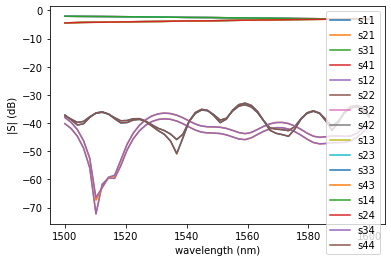

In [29]:
gf.simulation.plot.plot_sparameters(df)

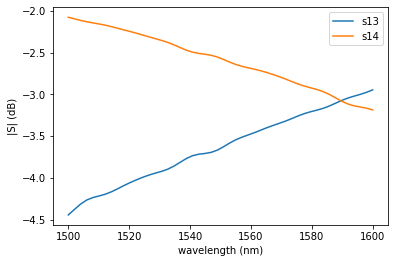

In [30]:
gf.simulation.plot.plot_sparameters(df, keys=["s13m", "s14m"])

## Batch

You can also run a batch of multicore simulations

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdsfactory as gf

import gdsfactory.simulation as sim
import gdsfactory.simulation.gmeep as gm

In [32]:
c = gf.components.straight(length=3.1)

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep/__init__.py:4472: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


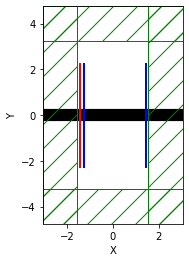

In [33]:
gm.write_sparameters_meep(c, ymargin=3, run=False)

In [34]:
c1_dict = {"component": c, "ymargin": 3}
jobs = [
    c1_dict,
]

filepaths = gm.write_sparameters_meep_batch_1x1(
    jobs=jobs,
    cores_per_run=4,
    total_cores=8,
    lazy_parallelism=True,
)

2022-06-30 06:12:38.859 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:139 - Simulation PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/straight_length3p1_5332dc15.csv') not found. Adding it to the queue


2022-06-30 06:12:38.861 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:147 - Running 1 simulations


2022-06-30 06:12:38.863 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:148 - total_cores = 8 with cores_per_run = 4


2022-06-30 06:12:38.865 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:149 - Running 1 batches with up to 2 jobs each.


  0%|          | 0/1 [00:00<?, ?it/s]

2022-06-30 06:12:38.894 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:160 - Task 0 of batch 0 is job 0


2022-06-30 06:12:38.896 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:140 - Simulation PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/straight_length3p1_a2a4b59a.csv') already exists


{'component': straight_length3p1: uid 42, ports ['o1', 'o2'], aliases [], 4 polygons, 0 references,
 'ymargin': 3}


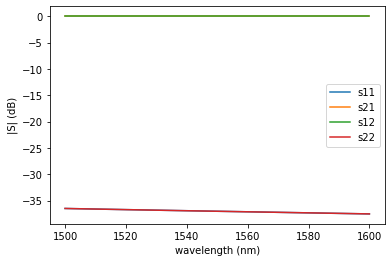

In [35]:
df = pd.read_csv(filepaths[0])
gf.simulation.plot.plot_sparameters(df)

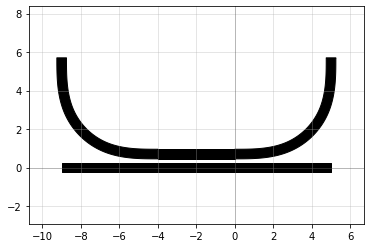

coupler_ring: uid 47, ports ['o2', 'o1', 'o3', 'o4'], aliases [], 0 polygons, 3 references

In [36]:
c = gf.components.coupler_ring()
c

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep/__init__.py:4472: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


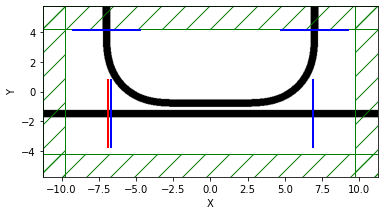

In [37]:
p = 2.5
gm.write_sparameters_meep(c, ymargin=0, ymargin_bot=p, xmargin=p, run=False)

In [38]:
c1_dict = dict(
    component=c,
    ymargin=0,
    ymargin_bot=p,
    xmargin=p,
)
jobs = [c1_dict]

filepaths = gm.write_sparameters_meep_batch(
    jobs=jobs,
    cores_per_run=4,
    total_cores=8,
    delete_temp_files=False,
    lazy_parallelism=True,
)

2022-06-30 06:12:45.094 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:139 - Simulation PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/coupler_ring_714aa5b6.csv') not found. Adding it to the queue


2022-06-30 06:12:45.096 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:147 - Running 1 simulations


2022-06-30 06:12:45.097 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:148 - total_cores = 8 with cores_per_run = 4


2022-06-30 06:12:45.098 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:149 - Running 1 batches with up to 2 jobs each.


  0%|          | 0/1 [00:00<?, ?it/s]

2022-06-30 06:12:45.119 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:160 - Task 0 of batch 0 is job 0


2022-06-30 06:12:45.122 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:140 - Simulation PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/coupler_ring_eea93f16.csv') already exists


{'component': coupler_ring: uid 47, ports ['o2', 'o1', 'o3', 'o4'], aliases [], 0 polygons, 3 references,
 'xmargin': 2.5,
 'ymargin': 0,
 'ymargin_bot': 2.5}


In [39]:
df = pd.read_csv(filepaths[0])

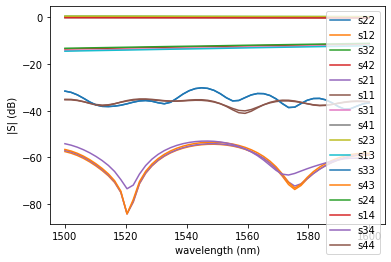

In [40]:
gm.plot.plot_sparameters(df)

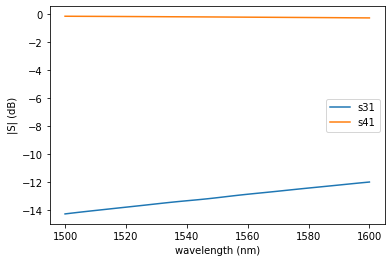

In [41]:
gm.plot.plot_sparameters(df, keys=["s31m", "s41m"])

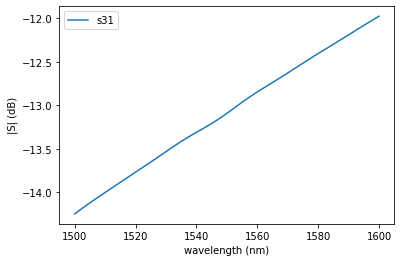

In [42]:
gm.plot.plot_sparameters(df, keys=["s31m"])

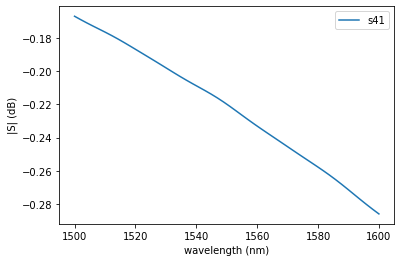

In [43]:
gm.plot.plot_sparameters(df, keys=["s41m"])